In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lab05_func import compute_points, calibrate_camera, stereo_calibration

## Kalibracja pojedyńczej kamery
### Wyliczanie współrzędnych punktów

In [3]:
l_objpoints, l_imgpoints, l_image_size, l_calibration_flags = compute_points("left")

### Kalibracja


In [4]:
l_tvecs, l_rvecs, l_K, l_D, l_map1, l_map2 = calibrate_camera(l_objpoints, l_imgpoints, l_image_size, l_calibration_flags)

### Usunięcie zniekształceń

In [5]:
def undistort_image(img_path, map1, map2):
    image = cv2.imread(img_path)

    undistorted_image = cv2.remap(
        image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT
    )
    
    _, ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title("original image")
    ax[1].imshow(undistorted_image)
    ax[1].set_title("undistorted image")
    ax[1].axis('off')
    plt.show()

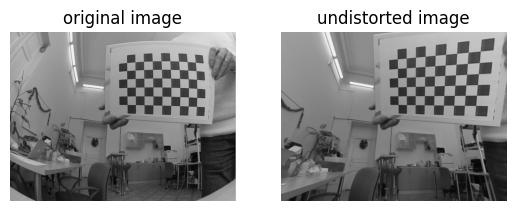

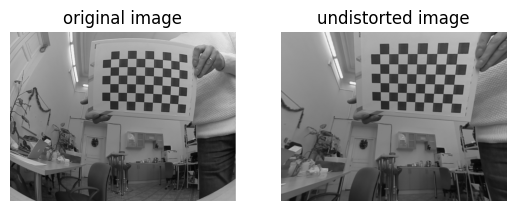

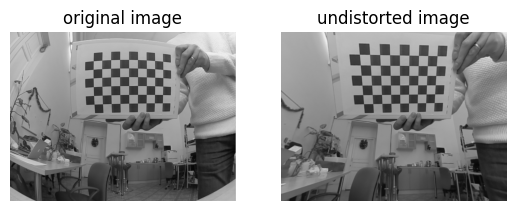

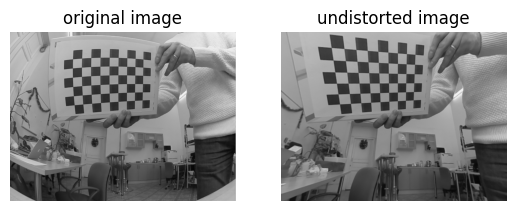

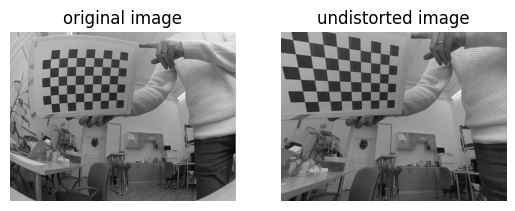

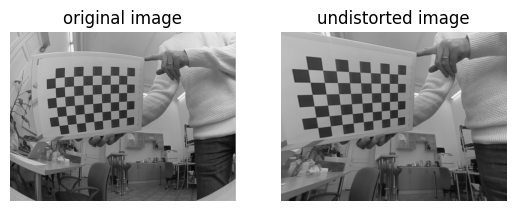

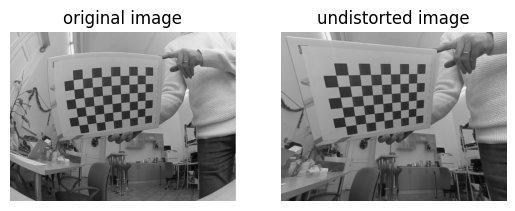

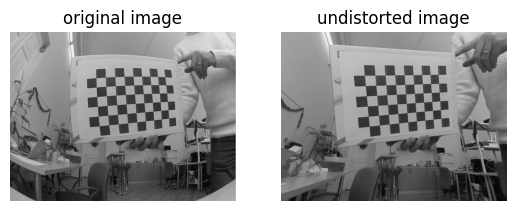

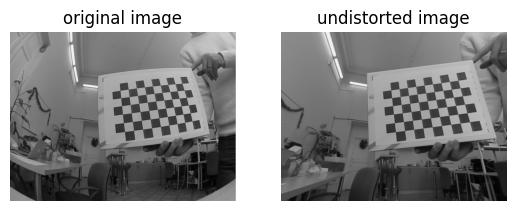

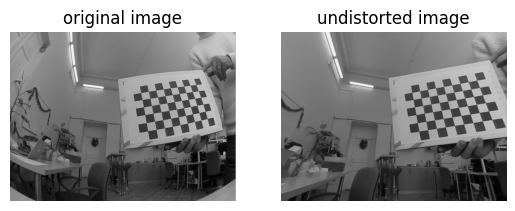

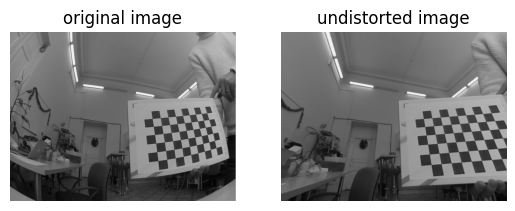

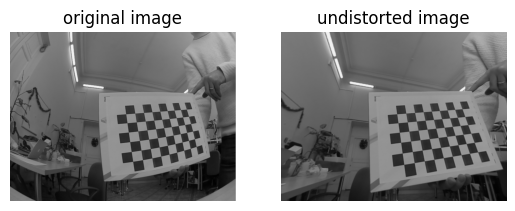

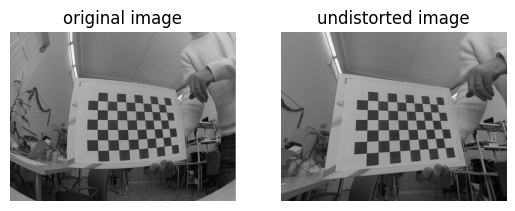

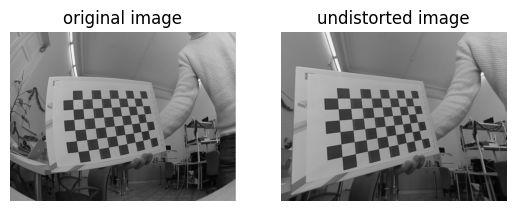

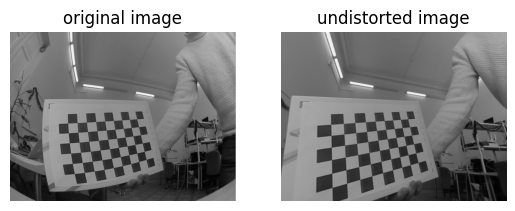

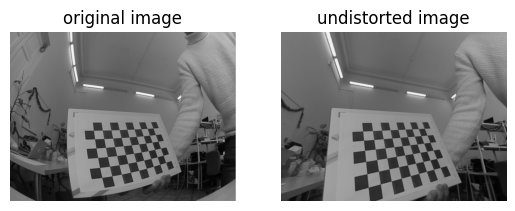

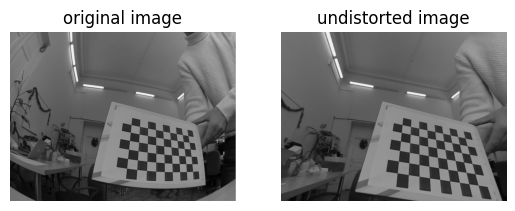

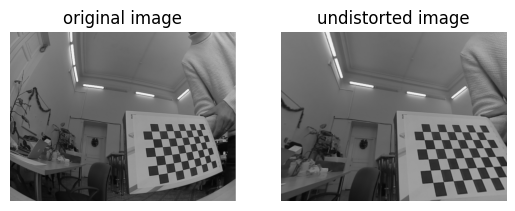

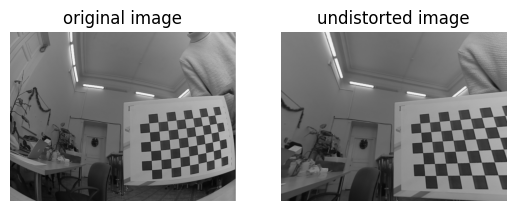

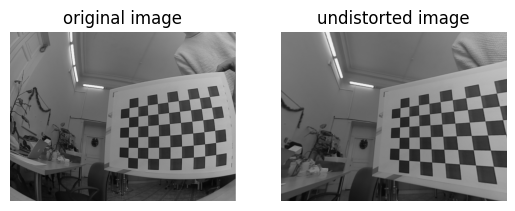

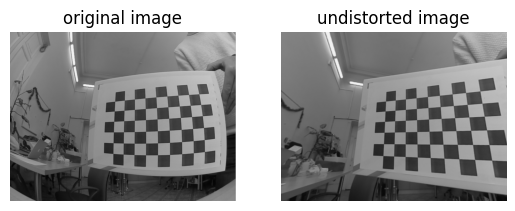

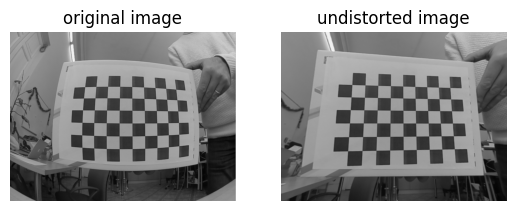

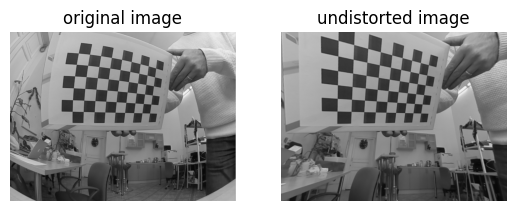

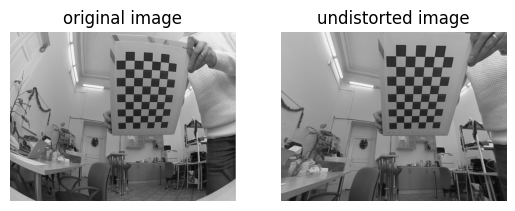

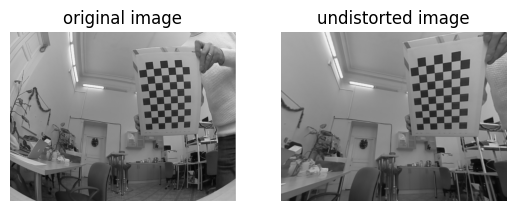

KeyboardInterrupt: 

In [6]:
import os

image_dir = "pairs"
image_extensions = (".jpg", ".jpeg", ".png")

for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            img_path = os.path.join(root, file)
            undistort_image(img_path, l_map1, l_map2)

In [7]:
l_K, r_K, l_D, r_D, objpoints, l_imgpoints, r_imgpoints, image_size = stereo_calibration()

l_imgpoints = np.asarray(l_imgpoints, dtype=np.float64)
r_imgpoints = np.asarray(r_imgpoints, dtype=np.float64)
(RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
    objpoints,
    l_imgpoints,
    r_imgpoints,
    l_K,
    l_D,
    r_K,
    r_D,
    image_size,
    None,
    None,
    cv2.CALIB_FIX_INTRINSIC,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
)
R2 = np.zeros([3, 3])
P1 = np.zeros([3, 4])
P2 = np.zeros([3, 4])
Q = np.zeros([4, 4])
# Rectify calibration results
(
    leftRectification,
    rightRectification,
    leftProjection,
    rightProjection,
    dispartityToDepthMap
) = cv2.fisheye.stereoRectify(
    l_K,
    l_D,
    r_K,
    r_D,
    image_size,
    rotationMatrix,
    translationVector,
    0,
    R2,
    P1,
    P2,
    Q,
    cv2.CALIB_ZERO_DISPARITY,
    (0, 0),
    0,
    0
)
map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
    l_K, l_D, leftRectification, leftProjection, image_size, cv2.CV_16SC2
)
map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
    r_K, r_D, rightRectification, rightProjection, image_size, cv2.CV_16SC2
)

In [8]:
image_dir = "pairs/"
img_l = cv2.imread(image_dir + f"left_49.png")
img_r = cv2.imread(image_dir + f"right_49.png")

dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

N, XX, YY = dst_L.shape[::-1]  # RGB image size
visRectify = np.zeros(
    (YY, XX * 2, N), np.uint8
)  # create a new image with a new size ( height , 2* width )
visRectify[:, 0:XX:, :] = dst_L  # left image assignment
visRectify[:, XX : XX * 2 :, :] = dst_R  # right image assignment
# draw horizontal lines
for y in range(0, YY, 10):
    cv2.line(visRectify, (0, y), (XX * 2, y), (255, 0, 0))
    
# visRectify = cv2.cvtColor(visRectify, cv2.COLOR_BGR2RGB)
# plt.imshow(visRectify)
# plt.axis('off')
# plt.show()
cv2.imshow("visRectify", visRectify)  # display image with lines
cv2.waitKey(0)
    
cv2.destroyAllWindows()

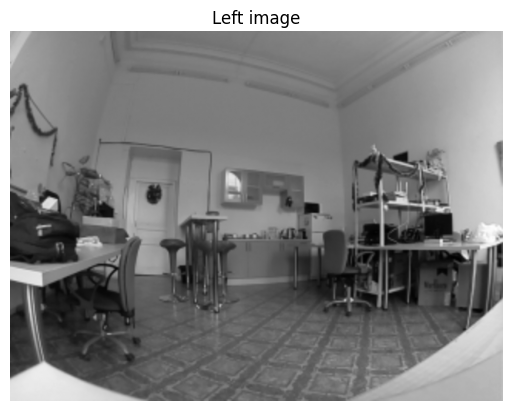

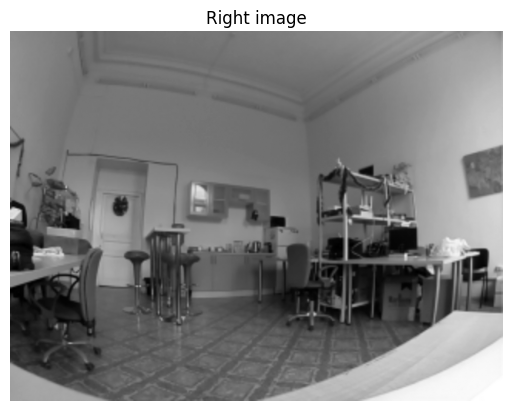

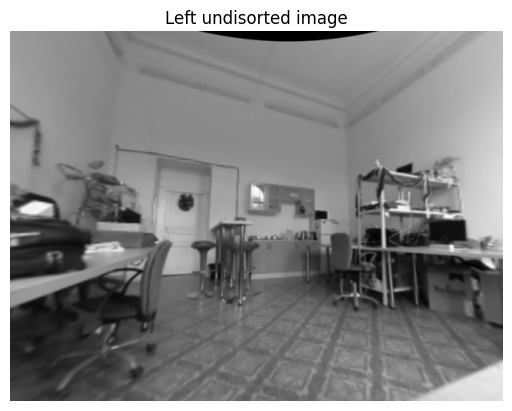

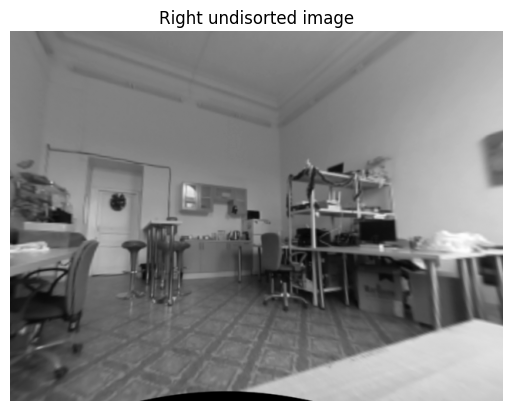

In [16]:
example = cv2.imread("example/example1.png", 0)
left = cv2.resize(example[:, :example.shape[1]//2], (dst_L.shape[1], dst_L.shape[0]))
right = cv2.resize(example[:, example.shape[1]//2:], (dst_R.shape[1], dst_R.shape[0]))
left_calib = cv2.remap(left, map1_left, map2_left, cv2.INTER_LINEAR)
right_calib = cv2.remap(right, map1_right, map2_right, cv2.INTER_LINEAR)

def show_image(image, title):
    plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(image, 'gray')
    

show_image(left, "Left image")
show_image(right, "Right image")
show_image(left_calib, "Left undisorted image")
show_image(right_calib, "Right undisorted image")


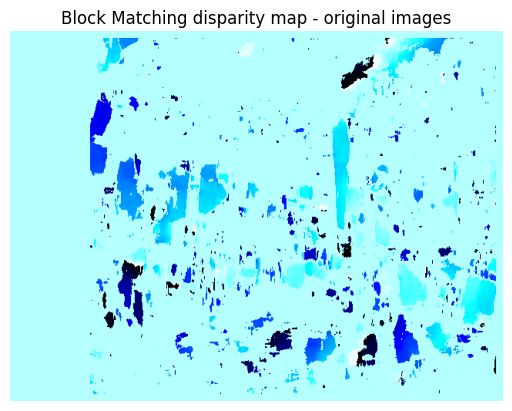

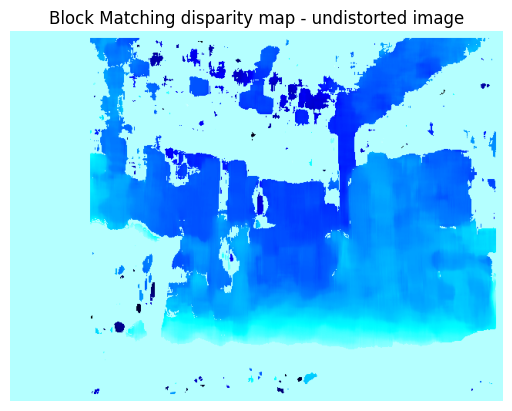

In [19]:
BM = cv2.StereoBM_create(numDisparities=16*6, blockSize=19)
disp_map = BM.compute(left, right).astype(np.uint8)
disp_map_calib = BM.compute(left_calib, right_calib).astype(np.uint8)

depth_map_bm = cv2.applyColorMap(disp_map, cv2.COLORMAP_HOT)
depth_map_bm_calib = cv2.applyColorMap(disp_map_calib, cv2.COLORMAP_HOT)

show_image(depth_map_bm, "Block Matching disparity map - original images")
show_image(depth_map_bm_calib, "Block Matching disparity map - undistorted image")

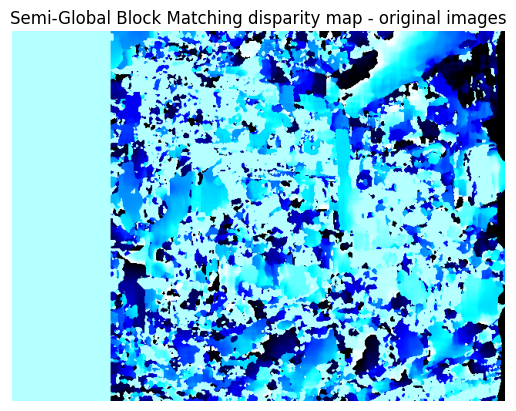

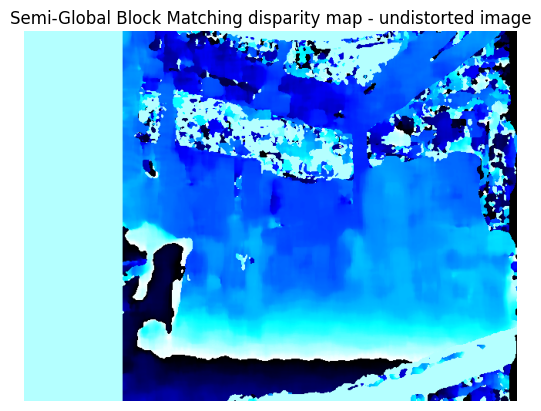

In [26]:
stereo_sgbm = cv2.StereoSGBM_create(numDisparities=16*8, blockSize=19)
disp_map = stereo_sgbm.compute(left, right).astype(np.uint8)
disp_map_calib = stereo_sgbm.compute(left_calib, right_calib).astype(np.uint8)
depth_map_sgbm = cv2.applyColorMap(disp_map, cv2.COLORMAP_HOT)
depth_map_sgbm_calib = cv2.applyColorMap(disp_map_calib, cv2.COLORMAP_HOT)

show_image(depth_map_sgbm, "Semi-Global Block Matching disparity map - original images")
show_image(depth_map_sgbm_calib, "Semi-Global Block Matching disparity map - undistorted image")